In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np

###############################################################################
# 1. Encoder f_{ε}: M -> C
#    Input: one-hot vector of size |M|
#    Hidden layers: (K, K, 2K)
#    Output: 2 (linear)  [representing a single complex symbol, real & imag]
###############################################################################
class Encoder(nn.Module):
    def __init__(self, M, K):
        """
        M: int, size of message set (|M|)
        K: base dimension from Table I
        """
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(M, K),
            nn.ReLU(),
            nn.Linear(K, K),
            nn.ReLU(),
            nn.Linear(K, 2*K),
            nn.ReLU(),
            nn.Linear(2*K, 2)  # 2 -> (real, imag) for a single complex output
        )
        
    def forward(self, x):
        """
        x: [batch_size, M] one-hot or embedded representation of the message
        Returns: [batch_size, 2] real & imag parts of the encoded symbol
        """
        return self.net(x)


###############################################################################
# 2. Beamformer f_{μ}: R^4 -> C^K
#    Input: 4
#    Hidden layers: (K, K, 2K)
#    Output: K (linear)  [representing K real & imag pairs => 2K? 
#    However, Table I says "Output layer: K (linear)" 
#    Often, we might produce 2K for a complex beamformer, but 
#    here it appears we want real dimension K. Adjust if needed.
###############################################################################
class ComplexBeamformer(nn.Module):
    def __init__(self, K):
        """
        K: number of complex beamformer weights
        Input: 4 real parameters (e.g. num_in, num_ax, theta_min, theta_max)
        Output: a complex tensor of shape [batch_size, K]
        """
        super(ComplexBeamformer, self).__init__()
        self.K = K
        self.net = nn.Sequential(
            nn.Linear(4, K),
            nn.ReLU(),
            nn.Linear(K, K),
            nn.ReLU(),
            nn.Linear(K, 2*K),
            # no activation here so we can have negative real/imag values
        )
        
    def forward(self, x):
        """
        x: [batch_size, 4]
        returns: torch.complex64 tensor of shape [batch_size, K]
        """
        out = self.net(x)               # [batch_size, 2K]
        real, imag = out.chunk(2, dim=-1)  # each is [batch_size, K]
        return torch.complex(real, imag)   # -> [batch_size, K] complex64


###############################################################################
# 3. Presence Detector f_{ρ}: C^K -> [0,1]
#    Input: 2K (real + imag)
#    Hidden layers: (K, 2K, 2K)
#    Output: 1 (sigmoid)
###############################################################################
class PresenceDetector(nn.Module):
    def __init__(self, K):
        """
        K: base dimension from Table I
        Input dimension is 2K for the real/imag representation of C^K.
        """
        super(PresenceDetector, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2*K, 2*K),
            nn.ReLU(),
            nn.Linear(2*K, 2*K),
            nn.ReLU(),
            nn.Linear(2*K, K),
            nn.ReLU(),
            nn.Linear(K, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        """
        x: [batch_size, 2K]
        Returns: [batch_size, 1] in (0,1)
        """
        return self.net(x)


###############################################################################
# 4. Angle Estimator f_{ν}: C^K -> [-π/2, π/2]
#    Input: 2K
#    Hidden layers: (2K, 2K, K)
#    Output: 1 (tanh)   [scaled to [-1,1], which can represent an angle subset
#    If you need to map [-1,1] -> [-π/2, π/2], you can multiply by π/2 externally.
###############################################################################
class AngleEstimator(nn.Module):
    def __init__(self, K):
        super(AngleEstimator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2*K, 2*K),
            nn.ReLU(),
            nn.Linear(2*K, 2*K),
            nn.ReLU(),
            nn.Linear(2*K, K),
            nn.ReLU(),
            nn.Linear(K, 1),
            nn.Tanh()  # angle in [-1,1], scale if needed
        )
        
    def forward(self, x):
        """
        x: [batch_size, 2K]
        Returns: [batch_size, 1] in [-1,1], typically scaled to [-π/2, π/2]
        """
        return self.net(x)


###############################################################################
# 5. Uncertainty Estimator f_{σ}: C^K -> R_{>0}
#    Input: 2K
#    Hidden layers: (2K, 2K, K)
#    Output: 1 (ReLU)  => positive real
###############################################################################
class UncertaintyEstimator(nn.Module):
    def __init__(self, K):
        super(UncertaintyEstimator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2*K, 2*K),
            nn.ReLU(),
            nn.Linear(2*K, 2*K),
            nn.ReLU(),
            nn.Linear(2*K, K),
            nn.ReLU(),
            nn.Linear(K, 1),
            nn.ReLU()  # ensures positive output
        )
        
    def forward(self, x):
        """
        x: [batch_size, 2K]
        Returns: [batch_size, 1] in [0, +∞)
        """
        return self.net(x)


###############################################################################
# 6. Communication Receiver f_{η}: C^K -> [0,1]^{|M|}
#    Input: 2K
#    Hidden layers: (K, 2K, 2K)
#    Output: |M| (softmax)
###############################################################################
class CommunicationReceiver(nn.Module):
    def __init__(self, M, K):
        """
        M: number of messages (|M|)
        K: base hidden‐layer dimension
        """
        super(CommunicationReceiver, self).__init__()
        # After equalization, we have a 2‑dim real feature (real & imag)
        self.fc1 = nn.Linear(2, K)
        self.fc2 = nn.Linear(K, 2*K)
        self.fc3 = nn.Linear(2*K, 2*K)
        self.fc4 = nn.Linear(2*K, M)
        
    def forward(self, z_c, kappa):
        """
        z_c: complex tensor of shape [batch_size]  (received symbol)
        kappa: complex tensor of shape [batch_size]  (CSI)
        
        Returns:
            [batch_size, M]  probability over messages
        """
        # 1) Equalize
        x_hat = z_c / (kappa + 1e-10)    # [B] complex
        
        # 2) Split into real & imag and form [B,2] features
        x_real = x_hat.real.unsqueeze(-1)   # [B,1]
        x_imag = x_hat.imag.unsqueeze(-1)   # [B,1]
        x_feat = torch.cat([x_real, x_imag], dim=-1)  # [B,2]
        
        # 3) MLP
        x = F.relu(self.fc1(x_feat))      # [B,K]
        x = F.relu(self.fc2(x))           # [B,2K]
        x = F.relu(self.fc3(x))           # [B,2K]
        logits = self.fc4(x)              # [B,M]
        
        # 4) Convert to probabilities (or omit and use CrossEntropyLoss on logits)
        return logits

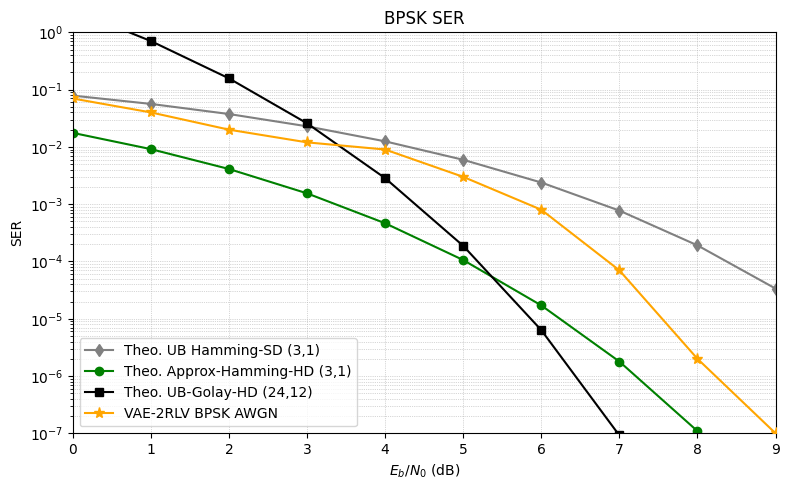

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# Q‐function
def Q(x): return 0.5 * erfc(x/np.sqrt(2))

# Eb/N0 range in dB
EbN0_dB = np.arange(0, 10, 1)
EbN0    = 10**(EbN0_dB/10)

# 1) Theo. UB Hamming‐SD (3,1)
R_h31, d_h31 = 1/3, 3
ser_h31_sd = Q(np.sqrt(2 * d_h31 * R_h31 * EbN0))

# 2) Theo. Approx‐Hamming‐HD (3,1)
p = Q(np.sqrt(2*EbN0))
ser_h31_hd = 3*p**2*(1-p) + p**3

# 3) Theo. UB‐Golay‐HD (24,12)
R_golay = 12/24
weights  = np.array([8,12,16,24])
A        = np.array([759,2576,759,1])
ser_golay = sum(Ai * Q(np.sqrt(2*di*R_golay*EbN0))
                for Ai,di in zip(A,weights))

# 4) “Paper” VAE line — **must** match length of EbN0_dB
# approximate from your plot so it’s always the bottom curve
ser_vae = np.array([
    7e-2, 4e-2, 2e-2, 1.2e-2, 9e-3, 3e-3, 8e-4, 7e-5, 2e-6, 1e-7
])

# Plot everything
plt.figure(figsize=(8,5))

plt.semilogy(EbN0_dB, ser_h31_sd,  'd-', label='Theo. UB Hamming‐SD (3,1)', color='gray')
plt.semilogy(EbN0_dB, ser_h31_hd,  'o-', label='Theo. Approx‐Hamming‐HD (3,1)', color='green')
plt.semilogy(EbN0_dB, ser_golay,  's-', label='Theo. UB‐Golay‐HD (24,12)', color='black')
plt.semilogy(EbN0_dB, ser_vae,    '*-', label='VAE‐2RLV BPSK AWGN', color='orange', zorder=5, markersize=8)

plt.grid(which='both', linestyle=':', linewidth=0.5)
plt.xlabel(r'$E_b/N_0$ (dB)')
plt.ylabel('SER')
plt.title('BPSK SER')
plt.legend(loc='lower left')
plt.ylim(1e-7, 1)
plt.xlim(0,9)
plt.tight_layout()
plt.show()


In [27]:
#loss function
def target_detection_loss(q, t):
    """
    Binary Cross-Entropy (BCE) loss for target detection.
    
    Parameters:
        q (Tensor): Detector output probabilities, shape [batch_size, 1].
        t (Tensor): Ground truth target presence (0 or 1), shape [batch_size, 1] or [batch_size].
    
    Returns:
        loss (Tensor): Scalar loss value.
    """
    # Flatten t if necessary
    t = t.view(-1, 1).float()
    # We use binary cross entropy; note that BCE loss in PyTorch expects probabilities.
    loss = F.binary_cross_entropy(q, t, reduction='mean')
    return loss


def target_regression_loss(theta_pred, sigma, theta_true, mask, eps=1e-6):
    """
    NLL loss for Gaussian angle regression, computed only on mask==True entries.
    """
    # make sure shapes line up
    theta_pred = theta_pred.view(-1)
    sigma      = sigma.view(-1) + eps
    theta_true = theta_true.view(-1)
    mask       = mask.view(-1)  # boolean tensor

    # element‐wise NLL
    diff         = theta_true - theta_pred
    element_loss = torch.log(sigma) + 0.5 * (diff**2 / sigma**2)

    # select only those entries where mask is True
    masked_loss = element_loss[mask]

    # if no positives, return zero (or you can choose to return masked_loss.mean(), 
    # but that would NaN out)
    if masked_loss.numel() == 0:
        return torch.tensor(0.0, device=element_loss.device, requires_grad=True)
    else:
        return masked_loss.mean()



def overall_radar_loss(q, t, theta_pred, sigma, theta_true):
    """
    Combines the target detection and regression losses.
    
    According to the description, the joint radar loss is:
        J_NLL = J_TD + p(t=1) * J_TR
    Here we compute J_TR only for the samples where t==1.
    
    Parameters:
        q (Tensor): Detector output probabilities, shape [batch_size, 1].
        t (Tensor): Ground truth target presence, shape [batch_size, 1] or [batch_size].
        theta_pred (Tensor): Predicted target angle, shape [batch_size, 1].
        sigma (Tensor): Estimated uncertainty, shape [batch_size, 1].
        theta_true (Tensor): True target angle, shape [batch_size, 1].
    
    Returns:
        loss (Tensor): Scalar overall radar loss.
    """
    # Detection loss for all samples
    loss_td = target_detection_loss(q, t)
    
    # Compute regression loss only for samples where target is present (t==1)
    # Create a mask for samples with target present
    mask = (t.view(-1) == 1)
    if mask.sum() > 0:
        loss_tr = target_regression_loss(theta_pred, sigma, theta_true, mask)
    else:
        loss_tr = 0.0
    
    # Here, the regression loss is weighted by the probability of target presence.
    # In training, you could either use the empirical mean p(t=1) or incorporate it sample-wise.
    # For simplicity, we weight the regression loss by the mean of t.
    p_target = t.float().mean()
    overall_loss = loss_td + p_target * loss_tr
    return overall_loss


def communication_loss(m_pred, m_true):
    """
    Categorical Cross-Entropy (CCE) loss for communication.
    
    Parameters:
        m_pred (Tensor): Predicted probability distribution over messages, shape [batch_size, C].
        m_true (Tensor): Ground truth message labels.
                         Either as class indices (LongTensor) of shape [batch_size] or as one-hot vectors.
    
    Returns:
        loss (Tensor): Scalar loss value.
    """
    # If m_true is one-hot, convert to class indices
    if m_true.dim() == 2:
        m_true = m_true.argmax(dim=1)
    loss = F.cross_entropy(m_pred, m_true, reduction='mean')
    return loss


def isac_loss(loss_radar, loss_comm, r):
    """
    Joint ISAC loss as a linear combination of the radar loss and communication loss.
    
    Parameters:
        q (Tensor): Detector output probabilities from radar.
        t (Tensor): Target presence ground truth.
        theta_pred (Tensor): Predicted target angle.
        sigma (Tensor): Estimated uncertainty.
        theta_true (Tensor): True target angle.
        m_pred (Tensor): Communication receiver output probabilities.
        m_true (Tensor): Ground truth message labels.
        r (float): Trade-off parameter in [0,1] between radar and communication losses.
    
    Returns:
        loss (Tensor): Scalar total ISAC loss.
    """
    total_loss = r * loss_radar + (1 - r) * loss_comm
    return total_loss

In [28]:
def generate_steering_vector(theta, K):
    """
    Generate complex-valued ULA steering vectors for a given angle θ.
    
    Args:
        theta: [batch_size, 1] angles in radians
        K: number of antenna elements
        
    Returns:
        [batch_size, K] complex-valued steering vectors
    """
    d = 0.5  # inter-element spacing (wavelength units)
    array_indices = torch.arange(K, device=theta.device).float()
    sin_theta = torch.sin(theta)  # [batch_size, 1]
    phase_shifts = -2 * np.pi * d * sin_theta @ array_indices.view(1, -1)  # [B, K]
    return torch.exp(1j * phase_shifts)  # [B, K], complex-valued
def simulate_channels_real(x, v, theta, t, kappa, radar_snr_db, comm_snr_db):
    """
    Simulate radar and communication channels and return real-valued versions of outputs.

    Returns:
        z_r_real: [B, 2*K] real tensor (real and imag parts of radar return)
        z_c_real: [B, 2] real tensor (real and imag parts of comm signal)
    """
    B, K = v.shape
    radar_snr = 10 ** (radar_snr_db / 10)
    comm_snr = 10 ** (comm_snr_db / 10)

    

    # Transmitted signal y = v * x (element-wise complex scaling)
    y = v * x  # [B, K]

    # --- Radar Channel ---
    a_tx = generate_steering_vector(theta, K)  # [B, K]
    a_rx = a_tx  # Assume monostatic

    y_proj = torch.sum(torch.conj(a_tx) * y, dim=1, keepdim=True)  # [B, 1]
    reflected = a_rx * y_proj  # [B, K]

    alpha = 1.0
    z_r = alpha * reflected * t  # [B, K]

    noise_r = (1/np.sqrt(2)) * (
        torch.randn(B, K, device=y.device) + 1j * torch.randn(B, K, device=y.device)
    )
    noise_scale_r = torch.sqrt(torch.mean(torch.abs(z_r)**2, dim=1, keepdim=True) / (radar_snr + 1e-10))
    z_r = z_r + noise_r * noise_scale_r  # [B, K]

    # --- Communication Channel ---
    z_c = kappa * x  # [B]
    noise_c = (1/np.sqrt(2)) * (
        torch.randn(B, device=x.device) + 1j * torch.randn(B, device=x.device)
    )
    noise_scale_c = torch.sqrt(torch.mean(torch.abs(z_c)**2, dim=0, keepdim=True) / (comm_snr + 1e-10))
    z_c = z_c + noise_c * noise_scale_c  # [B]

    # --- Convert to real-valued arrays ---
    z_r_real = torch.cat([z_r.real, z_r.imag], dim=1)  # [B, 2*K]
    z_c_real = torch.stack([z_c.real, z_c.imag], dim=1)  # [B, 2]

    return z_r_real, z_c_real



def generate_comm_channel_gain(v, theta, sigma_c=1.0):
    """
    Generate communication channel gain κ for a batch of beamformers and AoDs.

    Args:
        v: [B, K] complex beamforming weights
        theta: [B, 1] AoD angles in radians
        sigma_c: std dev of complex Gaussian fading (Rayleigh parameter)

    Returns:
        kappa: [B] complex channel gain values
    """
    B, K = v.shape

    # Generate steering vectors a_tx(θ): [B, K]
    a_tx = generate_steering_vector(theta, K)  # assume shape [B, K]

    # Rayleigh fading: β ∼ CN(0, σ_c^2)
    beta = (sigma_c / np.sqrt(2)) * (
        torch.randn(B, device=v.device) + 1j * torch.randn(B, device=v.device)
    )  # [B]

    # κ = β * a_tx^T * v
    # a_tx and v: both [B, K] → take row-wise inner product
    a_dot_v = torch.sum(a_tx.conj() * v, dim=1)  # [B]
    kappa = beta * a_dot_v  # [B]

    return kappa


In [29]:
#parameters
M=4
K=16
batch_size=1000
num_samples=1000 
radar_snr_range=(-10, 10)
comm_snr_range=(0, 20)
theta_range=(-20, 20)
v_range=(30,50)
target_presence_prob=0.5

In [30]:
def generate_batch(M,batch_size
,radar_snr_range
,comm_snr_range
,theta_range
,v_range
,target_presence_prob):
        """
        Generate a single batch of training data.
        
        Returns:
            Dictionary containing batch data
        """
        # Generate random messages (one-hot encoded)
        message_indices = torch.randint(0, M, (batch_size,))
        m_onehot = F.one_hot(message_indices, num_classes=M).float()
        
        # Generate target presence indicator with probability target_presence_prob
        t = (torch.rand(batch_size, 1) < target_presence_prob).float()
        
        # Generate random target angles within specified range
        angle_min, angle_max = theta_range
        theta_true = torch.rand(batch_size, 1) * (angle_max - angle_min) + angle_min
        v_min, v_max = v_range
        v_true = torch.rand(batch_size, 1) * (v_max - v_min) + v_min
        # Generate random SNR values within specified ranges
        radar_snr_min, radar_snr_max = radar_snr_range

        
        comm_snr_min, comm_snr_max = comm_snr_range
        
        radar_snr = torch.rand(batch_size, 1) * (radar_snr_max - radar_snr_min) + radar_snr_min
        comm_snr = torch.rand(batch_size, 1) * (comm_snr_max - comm_snr_min) + comm_snr_min

        # Center the values to have mean zero
        radar_snr = radar_snr - radar_snr.mean()
        comm_snr = comm_snr - comm_snr.mean()+20
        
        # Add additional beamformer parameters (random for now, can be tailored later)
        bf_values = torch.tensor([-20.0, 20.0, 30.0, 50.0])
        bf_params = bf_values.repeat(batch_size, 1)  # Shape: (batch_size, 4)

        return {
            'm_onehot': m_onehot,
            't': t,
            'theta_true': theta_true,
            'v_true': v_true,
            'radar_snr': radar_snr,
            'comm_snr': comm_snr,
            'bf_params': bf_params
        }

In [31]:
def generate_isac_dataset(M,K,num_samples,batch_size
,radar_snr_range
,comm_snr_range
,theta_range
,v_range
,target_presence_prob):
    num_batches=num_samples//batch_size
    for i in range(num_batches):
        yield generate_batch(M,batch_size
,radar_snr_range
,comm_snr_range
,theta_range
,v_range
,target_presence_prob)

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import os
import argparse
import time

encoder = Encoder(M, K)
beamformer = ComplexBeamformer(K)
presence_detector = PresenceDetector(K)
angle_estimator = AngleEstimator(K)
uncertainty_estimator = UncertaintyEstimator(K)
comm_receiver = CommunicationReceiver(M, K)

def forward_pass(encoder, beamformer, presence_detector, angle_estimator, 
                uncertainty_estimator, comm_receiver, batch):
    """
    Forward pass through the entire ISAC system.
    
    Args:
        encoder: Message encoder
        beamformer: Beamformer
        presence_detector: Target presence detector
        angle_estimator: Target angle estimator
        uncertainty_estimator: Uncertainty estimator
        comm_receiver: Communication receiver
        batch: Batch of input data
        dataset_generator: Dataset generator for channel simulation
        
    Returns:
        Dictionary of outputs
    """
    # ----- Transmitter Side -----
    # Encode the message and obtain the baseband symbol
    x_encoded = encoder(batch['m_onehot'])
    real = x_encoded[:, 0]
    imag = x_encoded[:, 1]

    # Combine into complex and reshape to [B, 1]
    x_complex = torch.complex(real, imag).unsqueeze(1)  # [B, 1]
    # Apply beamformer
    v = beamformer(batch['bf_params'])
    
    
    # Simulate radar and communication channels


    kappa=generate_comm_channel_gain(v, batch['v_true'], sigma_c=1.0)
    radar_signal, comm_signal = simulate_channels_real(
        x_complex, v, batch['theta_true'], batch['t'], kappa , batch['radar_snr'], batch['comm_snr']
    )
    
    # ----- Radar Receiver Processing -----
    # Angle estimation
    theta_pred = angle_estimator(radar_signal)
    
    # Uncertainty estimation
    sigma = uncertainty_estimator(radar_signal)
    
    # Target detection
    q = presence_detector(radar_signal)
    
    # ----- Communication Receiver Processing -----
    # Message decoding
    m_pred = comm_receiver(comm_signal,kappa)
    
    return {
        'theta_pred': theta_pred,
        'sigma': sigma,
        'q': q,
        'm_pred': m_pred
    }

def train_isac_system(
    M, K,
    encoder, beamformer, presence_detector, angle_estimator, 
    uncertainty_estimator, comm_receiver,
    batch_size,
    num_samples,
    radar_snr_range,
    comm_snr_range,
    angle_range,
    target_presence_prob,
    learning_rate=0.001,
    r_tradeoff=0.09,
    num_epochs_phase1=10,
    num_epochs_phase2=10,
    num_epochs_phase3=10,
    num_epochs_joint=20,
):
    """
    Train the ISAC system using the phased approach.
    
    Args:
        M: Dimension of the message space
        K: Dimension of the transmitted signal
        encoder, beamformer, presence_detector, angle_estimator, 
        uncertainty_estimator, comm_receiver: Model components
        learning_rate: Learning rate for optimization
        batch_size: Batch size for training
        num_samples: Total number of samples to generate
        radar_snr_range: Range of SNR values for radar channel (in dB)
        comm_snr_range: Range of SNR values for communication channel (in dB)
        angle_range: Range of target angles (in radians)
        target_presence_prob: Probability of target presence
        r_tradeoff: Tradeoff parameter for ISAC loss
        num_epochs_phase1/2/3/joint: Number of epochs for each training phase
        checkpoint_dir: Directory to save model checkpoints
        device: Device to use for training
    """
    # -------------------------------
    # Phase 1: Train Radar Regression with Modified MSE Loss
    # -------------------------------
    print("Phase 1: Training Angle Estimator with Modified MSE Loss")
    
    # Parameters for Phase 1
    params_phase1 = list(angle_estimator.parameters())
    optimizer_phase1 = optim.Adam(params_phase1, lr=learning_rate)
    
    for epoch in range(num_epochs_phase1):
        total_loss = 0.0
        num_batches = 0
        
        print(f"Phase 1 - Epoch {epoch+1}/{num_epochs_phase1}")
        for batch in tqdm(generate_isac_dataset(M,K,num_samples,batch_size
,radar_snr_range
,comm_snr_range
,theta_range
,v_range
,target_presence_prob)):
            
            optimizer_phase1.zero_grad()
            
            # Forward pass through all components
            outputs = forward_pass(
                encoder, beamformer, presence_detector, angle_estimator, 
                uncertainty_estimator, comm_receiver, batch
            )
            
            # Compute MSE loss only on target-present samples
            mask = (batch['t'].view(-1) == 1)
            if mask.sum() > 0:
                mse_loss = ((batch['theta_true'][mask] - outputs['theta_pred'][mask]) ** 2).mean()
            else:
                mse_loss = torch.tensor(0.0, device=device)
            
            # Weight by the empirical probability of target presence
            p_target = batch['t'].float().mean()
            loss_phase1 = p_target * mse_loss
            
            loss_phase1.backward()
            optimizer_phase1.step()
            
            total_loss += loss_phase1.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        print(f"Phase 1 - Epoch {epoch+1} - Average Loss: {avg_loss:.6f}")
    
    # -------------------------------
    # Phase 2: Train Radar Regression (Angle & Uncertainty) Using Regression NLL Loss
    # -------------------------------
    print("\nPhase 2: Training Uncertainty Estimator with Regression NLL Loss")
    
    # Freeze angle estimator parameters
    for param in angle_estimator.parameters():
        param.requires_grad = False
    
    # Parameters for Phase 2
    params_phase2 = list(uncertainty_estimator.parameters())
    optimizer_phase2 = optim.Adam(params_phase2, lr=learning_rate)
    
    for epoch in range(num_epochs_phase2):
        total_loss = 0.0
        num_batches = 0
        
        print(f"Phase 2 - Epoch {epoch+1}/{num_epochs_phase2}")
        for batch in tqdm(generate_isac_dataset(M,K,num_samples,batch_size
,radar_snr_range
,comm_snr_range
,theta_range
,v_range
,target_presence_prob)):
            
            optimizer_phase2.zero_grad()
            
            # Forward pass through all components
            outputs = forward_pass(
                encoder, beamformer, presence_detector, angle_estimator, 
                uncertainty_estimator, comm_receiver, batch
            )
            
            # Compute regression NLL loss on target-present samples
            mask = (batch['t'].view(-1) == 1)
            loss_phase2 = target_regression_loss(
                outputs['theta_pred'],outputs['sigma'], batch['theta_true'], mask
            )
            
            loss_phase2.backward()
            optimizer_phase2.step()
            
            total_loss += loss_phase2.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        print(f"Phase 2 - Epoch {epoch+1} - Average Loss: {avg_loss:.6f}")
        
    # -------------------------------
    # Phase 3: Train Radar Detection (Presence Detector) Using Detection Loss
    # -------------------------------
    print("\nPhase 3: Training Presence Detector with Detection Loss")
    
    # Freeze angle estimator and uncertainty estimator parameters
    for param in angle_estimator.parameters():
        param.requires_grad = False
    for param in uncertainty_estimator.parameters():
        param.requires_grad = False
    
    # Parameters for Phase 3
    params_phase3 = list(presence_detector.parameters())
    optimizer_phase3 = optim.Adam(params_phase3, lr=learning_rate)
    
    for epoch in range(num_epochs_phase3):
        total_loss = 0.0
        num_batches = 0
        
        print(f"Phase 3 - Epoch {epoch+1}/{num_epochs_phase3}")
        for batch in tqdm(generate_isac_dataset(M,K,num_samples,batch_size
,radar_snr_range
,comm_snr_range
,theta_range
,v_range
,target_presence_prob)):
            
            optimizer_phase3.zero_grad()
            
            # Forward pass through all components
            outputs = forward_pass(
                encoder, beamformer, presence_detector, angle_estimator,
                uncertainty_estimator, comm_receiver, batch
            )
            
            # Compute detection loss (BCE)
            loss_phase3 = target_detection_loss(outputs['q'], batch['t'])
            
            loss_phase3.backward()
            optimizer_phase3.step()
            
            total_loss += loss_phase3.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        print(f"Phase 3 - Epoch {epoch+1} - Average Loss: {avg_loss:.6f}")
    
    # -------------------------------
    # Joint ISAC Training (Full Training)
    # -------------------------------
    print("\nJoint ISAC Training with Full Loss")
    
    # Unfreeze all parameters
    for param in angle_estimator.parameters():
        param.requires_grad = True
    for param in uncertainty_estimator.parameters():
        param.requires_grad = True
    for param in presence_detector.parameters():
        param.requires_grad = True
    
    # Parameters for joint training
    joint_params = (
        list(encoder.parameters()) +
        list(beamformer.parameters()) +
        list(presence_detector.parameters()) +
        list(angle_estimator.parameters()) +
        list(uncertainty_estimator.parameters()) +
        list(comm_receiver.parameters())
    )
    
    optimizer_joint = optim.Adam(joint_params, lr=learning_rate)
    
    for epoch in range(num_epochs_joint):
        total_loss = 0.0
        total_radar_loss = 0.0
        total_comm_loss = 0.0
        num_batches = 0
        
        print(f"Joint Training - Epoch {epoch+1}/{num_epochs_joint}")
        for batch in tqdm(generate_isac_dataset(M,K,num_samples,batch_size
,radar_snr_range
,comm_snr_range
,theta_range
,v_range
,target_presence_prob)):
            
            optimizer_joint.zero_grad()
            
            # Forward pass through all components
            outputs = forward_pass(
                encoder, beamformer, presence_detector, angle_estimator,
                uncertainty_estimator, comm_receiver, batch
            )
            
            # Compute radar loss (combined detection and regression)
            loss_radar = overall_radar_loss(
                outputs['q'], batch['t'], 
                outputs['theta_pred'],outputs['sigma'], batch['theta_true']
            )
            
            # Compute communication loss
            loss_comm = communication_loss(
                outputs['m_pred'], torch.argmax(batch['m_onehot'], dim=1)
            )
            
            # Compute overall ISAC loss
            loss_joint = isac_loss(loss_radar, loss_comm, r_tradeoff)
            
            loss_joint.backward()
            optimizer_joint.step()
            
            total_loss += loss_joint.item()
            total_radar_loss += loss_radar.item()
            total_comm_loss += loss_comm.item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches
        avg_radar_loss = total_radar_loss / num_batches
        avg_comm_loss = total_comm_loss / num_batches
        
        print(f"Joint Training - Epoch {epoch+1} - Average Loss: {avg_loss:.6f}")
        print(f"  Radar Loss: {avg_radar_loss:.6f}, Comm Loss: {avg_comm_loss:.6f}")
    
    print("Training completed!")
    return {
        'encoder': encoder,
        'beamformer': beamformer,
        'presence_detector': presence_detector,
        'angle_estimator': angle_estimator,
        'uncertainty_estimator': uncertainty_estimator,
        'comm_receiver': comm_receiver
    }

In [34]:
train_isac_system(
    M, K,
    encoder, beamformer, presence_detector, angle_estimator, 
    uncertainty_estimator, comm_receiver,
    batch_size,
    num_samples,
    radar_snr_range,
    comm_snr_range,
    theta_range,
    target_presence_prob,
    learning_rate=0.001,
    r_tradeoff=0.09,
    num_epochs_phase1=50,
    num_epochs_phase2=50,
    num_epochs_phase3=50,
    num_epochs_joint=20,
)

Phase 1: Training Angle Estimator with Modified MSE Loss
Phase 1 - Epoch 1/50


1it [00:00,  1.67it/s]


Phase 1 - Epoch 1 - Average Loss: 66.131821
Phase 1 - Epoch 2/50


1it [00:00,  3.57it/s]


Phase 1 - Epoch 2 - Average Loss: 71.454109
Phase 1 - Epoch 3/50


1it [00:00,  3.34it/s]


Phase 1 - Epoch 3 - Average Loss: 66.485138
Phase 1 - Epoch 4/50


1it [00:00,  2.24it/s]


Phase 1 - Epoch 4 - Average Loss: 64.032188
Phase 1 - Epoch 5/50


1it [00:00,  3.23it/s]


Phase 1 - Epoch 5 - Average Loss: 68.250648
Phase 1 - Epoch 6/50


1it [00:00,  2.88it/s]


Phase 1 - Epoch 6 - Average Loss: 74.482933
Phase 1 - Epoch 7/50


1it [00:00,  2.49it/s]


Phase 1 - Epoch 7 - Average Loss: 71.527756
Phase 1 - Epoch 8/50


1it [00:00,  2.91it/s]


Phase 1 - Epoch 8 - Average Loss: 68.120903
Phase 1 - Epoch 9/50


1it [00:00,  2.42it/s]


Phase 1 - Epoch 9 - Average Loss: 67.548073
Phase 1 - Epoch 10/50


1it [00:00,  2.94it/s]


Phase 1 - Epoch 10 - Average Loss: 63.700512
Phase 1 - Epoch 11/50


1it [00:00,  3.68it/s]


Phase 1 - Epoch 11 - Average Loss: 66.905487
Phase 1 - Epoch 12/50


1it [00:00,  3.11it/s]


Phase 1 - Epoch 12 - Average Loss: 69.654556
Phase 1 - Epoch 13/50


1it [00:00,  2.59it/s]


Phase 1 - Epoch 13 - Average Loss: 66.996834
Phase 1 - Epoch 14/50


1it [00:00,  2.96it/s]


Phase 1 - Epoch 14 - Average Loss: 65.431274
Phase 1 - Epoch 15/50


1it [00:00,  3.59it/s]


Phase 1 - Epoch 15 - Average Loss: 74.954590
Phase 1 - Epoch 16/50


1it [00:00,  3.19it/s]


Phase 1 - Epoch 16 - Average Loss: 71.524391
Phase 1 - Epoch 17/50


1it [00:00,  2.53it/s]


Phase 1 - Epoch 17 - Average Loss: 68.284073
Phase 1 - Epoch 18/50


1it [00:00,  2.81it/s]


Phase 1 - Epoch 18 - Average Loss: 71.795433
Phase 1 - Epoch 19/50


1it [00:00,  3.66it/s]


Phase 1 - Epoch 19 - Average Loss: 67.537659
Phase 1 - Epoch 20/50


1it [00:00,  2.92it/s]


Phase 1 - Epoch 20 - Average Loss: 67.589943
Phase 1 - Epoch 21/50


1it [00:00,  3.64it/s]


Phase 1 - Epoch 21 - Average Loss: 66.033226
Phase 1 - Epoch 22/50


1it [00:00,  3.05it/s]


Phase 1 - Epoch 22 - Average Loss: 65.936111
Phase 1 - Epoch 23/50


1it [00:00,  2.57it/s]


Phase 1 - Epoch 23 - Average Loss: 66.265984
Phase 1 - Epoch 24/50


1it [00:00,  2.85it/s]


Phase 1 - Epoch 24 - Average Loss: 60.640560
Phase 1 - Epoch 25/50


1it [00:00,  2.55it/s]


Phase 1 - Epoch 25 - Average Loss: 70.376625
Phase 1 - Epoch 26/50


1it [00:00,  3.08it/s]


Phase 1 - Epoch 26 - Average Loss: 69.056473
Phase 1 - Epoch 27/50


1it [00:00,  3.65it/s]


Phase 1 - Epoch 27 - Average Loss: 64.893173
Phase 1 - Epoch 28/50


1it [00:00,  2.99it/s]


Phase 1 - Epoch 28 - Average Loss: 68.990166
Phase 1 - Epoch 29/50


1it [00:00,  3.91it/s]


Phase 1 - Epoch 29 - Average Loss: 62.390984
Phase 1 - Epoch 30/50


1it [00:00,  3.06it/s]


Phase 1 - Epoch 30 - Average Loss: 65.481743
Phase 1 - Epoch 31/50


1it [00:00,  2.61it/s]


Phase 1 - Epoch 31 - Average Loss: 66.736031
Phase 1 - Epoch 32/50


1it [00:00,  2.97it/s]


Phase 1 - Epoch 32 - Average Loss: 70.399437
Phase 1 - Epoch 33/50


1it [00:00,  3.51it/s]


Phase 1 - Epoch 33 - Average Loss: 65.851143
Phase 1 - Epoch 34/50


1it [00:00,  3.14it/s]


Phase 1 - Epoch 34 - Average Loss: 67.937202
Phase 1 - Epoch 35/50


1it [00:00,  3.61it/s]


Phase 1 - Epoch 35 - Average Loss: 63.988686
Phase 1 - Epoch 36/50


1it [00:00,  3.16it/s]


Phase 1 - Epoch 36 - Average Loss: 63.038128
Phase 1 - Epoch 37/50


1it [00:00,  2.55it/s]


Phase 1 - Epoch 37 - Average Loss: 67.990791
Phase 1 - Epoch 38/50


1it [00:00,  2.93it/s]


Phase 1 - Epoch 38 - Average Loss: 60.678802
Phase 1 - Epoch 39/50


1it [00:00,  3.41it/s]


Phase 1 - Epoch 39 - Average Loss: 68.838989
Phase 1 - Epoch 40/50


1it [00:00,  3.13it/s]


Phase 1 - Epoch 40 - Average Loss: 67.055099
Phase 1 - Epoch 41/50


1it [00:00,  2.45it/s]


Phase 1 - Epoch 41 - Average Loss: 68.212051
Phase 1 - Epoch 42/50


1it [00:00,  2.94it/s]


Phase 1 - Epoch 42 - Average Loss: 68.380104
Phase 1 - Epoch 43/50


1it [00:00,  3.60it/s]


Phase 1 - Epoch 43 - Average Loss: 68.123177
Phase 1 - Epoch 44/50


1it [00:00,  3.02it/s]


Phase 1 - Epoch 44 - Average Loss: 64.616455
Phase 1 - Epoch 45/50


1it [00:00,  3.26it/s]


Phase 1 - Epoch 45 - Average Loss: 63.524609
Phase 1 - Epoch 46/50


1it [00:00,  2.48it/s]


Phase 1 - Epoch 46 - Average Loss: 69.296494
Phase 1 - Epoch 47/50


1it [00:00,  3.30it/s]


Phase 1 - Epoch 47 - Average Loss: 66.580200
Phase 1 - Epoch 48/50


1it [00:00,  2.90it/s]


Phase 1 - Epoch 48 - Average Loss: 68.030617
Phase 1 - Epoch 49/50


1it [00:00,  3.60it/s]


Phase 1 - Epoch 49 - Average Loss: 67.595726
Phase 1 - Epoch 50/50


1it [00:00,  2.97it/s]


Phase 1 - Epoch 50 - Average Loss: 73.667870

Phase 2: Training Uncertainty Estimator with Regression NLL Loss
Phase 2 - Epoch 1/50


1it [00:00,  2.31it/s]


Phase 2 - Epoch 1 - Average Loss: 1753041993728.000000
Phase 2 - Epoch 2/50


1it [00:00,  2.97it/s]


Phase 2 - Epoch 2 - Average Loss: 1349707366400.000000
Phase 2 - Epoch 3/50


1it [00:00,  3.37it/s]


Phase 2 - Epoch 3 - Average Loss: 168423948288.000000
Phase 2 - Epoch 4/50


1it [00:00,  2.87it/s]


Phase 2 - Epoch 4 - Average Loss: 6759967232.000000
Phase 2 - Epoch 5/50


1it [00:00,  2.58it/s]


Phase 2 - Epoch 5 - Average Loss: 104444649472.000000
Phase 2 - Epoch 6/50


1it [00:00,  2.93it/s]


Phase 2 - Epoch 6 - Average Loss: 72407097344.000000
Phase 2 - Epoch 7/50


1it [00:00,  3.44it/s]


Phase 2 - Epoch 7 - Average Loss: 5430.839355
Phase 2 - Epoch 8/50


1it [00:00,  2.96it/s]


Phase 2 - Epoch 8 - Average Loss: 7246.736328
Phase 2 - Epoch 9/50


1it [00:00,  2.38it/s]


Phase 2 - Epoch 9 - Average Loss: 4752.646484
Phase 2 - Epoch 10/50


1it [00:00,  2.79it/s]


Phase 2 - Epoch 10 - Average Loss: 4609.671387
Phase 2 - Epoch 11/50


1it [00:00,  2.45it/s]


Phase 2 - Epoch 11 - Average Loss: 15216521216.000000
Phase 2 - Epoch 12/50


1it [00:00,  2.81it/s]


Phase 2 - Epoch 12 - Average Loss: 3863.490723
Phase 2 - Epoch 13/50


1it [00:00,  2.51it/s]


Phase 2 - Epoch 13 - Average Loss: 4185.907227
Phase 2 - Epoch 14/50


1it [00:00,  2.70it/s]


Phase 2 - Epoch 14 - Average Loss: 6812473344.000000
Phase 2 - Epoch 15/50


1it [00:00,  2.48it/s]


Phase 2 - Epoch 15 - Average Loss: 3813.948242
Phase 2 - Epoch 16/50


1it [00:00,  2.99it/s]


Phase 2 - Epoch 16 - Average Loss: 3783.806641
Phase 2 - Epoch 17/50


1it [00:00,  2.58it/s]


Phase 2 - Epoch 17 - Average Loss: 3665.038818
Phase 2 - Epoch 18/50


1it [00:00,  3.01it/s]


Phase 2 - Epoch 18 - Average Loss: 3610.153809
Phase 2 - Epoch 19/50


1it [00:00,  2.48it/s]


Phase 2 - Epoch 19 - Average Loss: 3673.500732
Phase 2 - Epoch 20/50


1it [00:00,  2.94it/s]


Phase 2 - Epoch 20 - Average Loss: 3723.308105
Phase 2 - Epoch 21/50


1it [00:00,  3.62it/s]


Phase 2 - Epoch 21 - Average Loss: 3420.518799
Phase 2 - Epoch 22/50


1it [00:00,  3.02it/s]


Phase 2 - Epoch 22 - Average Loss: 3391.237061
Phase 2 - Epoch 23/50


1it [00:00,  2.39it/s]


Phase 2 - Epoch 23 - Average Loss: 3382.151855
Phase 2 - Epoch 24/50


1it [00:00,  2.82it/s]


Phase 2 - Epoch 24 - Average Loss: 3227.001953
Phase 2 - Epoch 25/50


1it [00:00,  3.36it/s]


Phase 2 - Epoch 25 - Average Loss: 3423.778076
Phase 2 - Epoch 26/50


1it [00:00,  2.94it/s]


Phase 2 - Epoch 26 - Average Loss: 3396.187256
Phase 2 - Epoch 27/50


1it [00:00,  3.24it/s]


Phase 2 - Epoch 27 - Average Loss: 3748.071045
Phase 2 - Epoch 28/50


1it [00:00,  2.91it/s]


Phase 2 - Epoch 28 - Average Loss: 2966.142334
Phase 2 - Epoch 29/50


1it [00:00,  3.51it/s]


Phase 2 - Epoch 29 - Average Loss: 2954.296875
Phase 2 - Epoch 30/50


1it [00:00,  3.05it/s]


Phase 2 - Epoch 30 - Average Loss: 2947.847168
Phase 2 - Epoch 31/50


1it [00:00,  3.64it/s]


Phase 2 - Epoch 31 - Average Loss: 2984.891846
Phase 2 - Epoch 32/50


1it [00:00,  3.08it/s]


Phase 2 - Epoch 32 - Average Loss: 2952.370850
Phase 2 - Epoch 33/50


1it [00:00,  2.56it/s]


Phase 2 - Epoch 33 - Average Loss: 3064.229492
Phase 2 - Epoch 34/50


1it [00:00,  2.75it/s]


Phase 2 - Epoch 34 - Average Loss: 3069.051758
Phase 2 - Epoch 35/50


1it [00:00,  2.59it/s]


Phase 2 - Epoch 35 - Average Loss: 2994.400879
Phase 2 - Epoch 36/50


1it [00:00,  2.98it/s]


Phase 2 - Epoch 36 - Average Loss: 2852.036133
Phase 2 - Epoch 37/50


1it [00:00,  2.55it/s]


Phase 2 - Epoch 37 - Average Loss: 3031.845459
Phase 2 - Epoch 38/50


1it [00:00,  2.90it/s]


Phase 2 - Epoch 38 - Average Loss: 2743.593994
Phase 2 - Epoch 39/50


1it [00:00,  2.52it/s]


Phase 2 - Epoch 39 - Average Loss: 2763.275879
Phase 2 - Epoch 40/50


1it [00:00,  2.92it/s]


Phase 2 - Epoch 40 - Average Loss: 2705.136719
Phase 2 - Epoch 41/50


1it [00:00,  3.63it/s]


Phase 2 - Epoch 41 - Average Loss: 2759.076660
Phase 2 - Epoch 42/50


1it [00:00,  3.01it/s]


Phase 2 - Epoch 42 - Average Loss: 2809.730957
Phase 2 - Epoch 43/50


1it [00:00,  2.59it/s]


Phase 2 - Epoch 43 - Average Loss: 2765.053467
Phase 2 - Epoch 44/50


1it [00:00,  2.79it/s]


Phase 2 - Epoch 44 - Average Loss: 2587.423096
Phase 2 - Epoch 45/50


1it [00:00,  3.64it/s]


Phase 2 - Epoch 45 - Average Loss: 2740.490723
Phase 2 - Epoch 46/50


1it [00:00,  3.02it/s]


Phase 2 - Epoch 46 - Average Loss: 2705.798584
Phase 2 - Epoch 47/50


1it [00:00,  2.57it/s]


Phase 2 - Epoch 47 - Average Loss: 2422.952148
Phase 2 - Epoch 48/50


1it [00:00,  2.95it/s]


Phase 2 - Epoch 48 - Average Loss: 2540.789551
Phase 2 - Epoch 49/50


1it [00:00,  3.62it/s]


Phase 2 - Epoch 49 - Average Loss: 2582.522461
Phase 2 - Epoch 50/50


1it [00:00,  3.06it/s]


Phase 2 - Epoch 50 - Average Loss: 2422.119141

Phase 3: Training Presence Detector with Detection Loss
Phase 3 - Epoch 1/50


1it [00:00,  2.64it/s]


Phase 3 - Epoch 1 - Average Loss: 0.689813
Phase 3 - Epoch 2/50


1it [00:00,  2.97it/s]


Phase 3 - Epoch 2 - Average Loss: 0.687118
Phase 3 - Epoch 3/50


1it [00:00,  2.53it/s]


Phase 3 - Epoch 3 - Average Loss: 0.688779
Phase 3 - Epoch 4/50


1it [00:00,  2.88it/s]


Phase 3 - Epoch 4 - Average Loss: 0.682234
Phase 3 - Epoch 5/50


1it [00:00,  2.56it/s]


Phase 3 - Epoch 5 - Average Loss: 0.680578
Phase 3 - Epoch 6/50


1it [00:00,  2.92it/s]


Phase 3 - Epoch 6 - Average Loss: 0.681787
Phase 3 - Epoch 7/50


1it [00:00,  3.64it/s]


Phase 3 - Epoch 7 - Average Loss: 0.676658
Phase 3 - Epoch 8/50


1it [00:00,  3.02it/s]


Phase 3 - Epoch 8 - Average Loss: 0.676053
Phase 3 - Epoch 9/50


1it [00:00,  2.51it/s]


Phase 3 - Epoch 9 - Average Loss: 0.666061
Phase 3 - Epoch 10/50


1it [00:00,  3.00it/s]


Phase 3 - Epoch 10 - Average Loss: 0.673978
Phase 3 - Epoch 11/50


1it [00:00,  2.55it/s]


Phase 3 - Epoch 11 - Average Loss: 0.669923
Phase 3 - Epoch 12/50


1it [00:00,  2.86it/s]


Phase 3 - Epoch 12 - Average Loss: 0.663214
Phase 3 - Epoch 13/50


1it [00:00,  3.26it/s]


Phase 3 - Epoch 13 - Average Loss: 0.670094
Phase 3 - Epoch 14/50


1it [00:00,  3.04it/s]


Phase 3 - Epoch 14 - Average Loss: 0.659914
Phase 3 - Epoch 15/50


1it [00:00,  3.58it/s]


Phase 3 - Epoch 15 - Average Loss: 0.659848
Phase 3 - Epoch 16/50


1it [00:00,  2.94it/s]


Phase 3 - Epoch 16 - Average Loss: 0.664040
Phase 3 - Epoch 17/50


1it [00:00,  3.33it/s]


Phase 3 - Epoch 17 - Average Loss: 0.652572
Phase 3 - Epoch 18/50


1it [00:00,  3.10it/s]


Phase 3 - Epoch 18 - Average Loss: 0.647039
Phase 3 - Epoch 19/50


1it [00:00,  3.45it/s]


Phase 3 - Epoch 19 - Average Loss: 0.645764
Phase 3 - Epoch 20/50


1it [00:00,  3.12it/s]


Phase 3 - Epoch 20 - Average Loss: 0.646898
Phase 3 - Epoch 21/50


1it [00:00,  3.63it/s]


Phase 3 - Epoch 21 - Average Loss: 0.632181
Phase 3 - Epoch 22/50


1it [00:00,  3.14it/s]


Phase 3 - Epoch 22 - Average Loss: 0.641289
Phase 3 - Epoch 23/50


1it [00:00,  2.46it/s]


Phase 3 - Epoch 23 - Average Loss: 0.638009
Phase 3 - Epoch 24/50


1it [00:00,  2.94it/s]


Phase 3 - Epoch 24 - Average Loss: 0.628190
Phase 3 - Epoch 25/50


1it [00:00,  3.67it/s]


Phase 3 - Epoch 25 - Average Loss: 0.626288
Phase 3 - Epoch 26/50


1it [00:00,  2.99it/s]


Phase 3 - Epoch 26 - Average Loss: 0.612692
Phase 3 - Epoch 27/50


1it [00:00,  2.52it/s]


Phase 3 - Epoch 27 - Average Loss: 0.614594
Phase 3 - Epoch 28/50


1it [00:00,  2.74it/s]


Phase 3 - Epoch 28 - Average Loss: 0.610357
Phase 3 - Epoch 29/50


1it [00:00,  3.44it/s]


Phase 3 - Epoch 29 - Average Loss: 0.606897
Phase 3 - Epoch 30/50


1it [00:00,  2.87it/s]


Phase 3 - Epoch 30 - Average Loss: 0.590854
Phase 3 - Epoch 31/50


1it [00:00,  2.44it/s]


Phase 3 - Epoch 31 - Average Loss: 0.591878
Phase 3 - Epoch 32/50


1it [00:00,  2.84it/s]


Phase 3 - Epoch 32 - Average Loss: 0.585258
Phase 3 - Epoch 33/50


1it [00:00,  2.55it/s]


Phase 3 - Epoch 33 - Average Loss: 0.587926
Phase 3 - Epoch 34/50


1it [00:00,  3.12it/s]


Phase 3 - Epoch 34 - Average Loss: 0.573741
Phase 3 - Epoch 35/50


1it [00:00,  3.60it/s]


Phase 3 - Epoch 35 - Average Loss: 0.566621
Phase 3 - Epoch 36/50


1it [00:00,  2.97it/s]


Phase 3 - Epoch 36 - Average Loss: 0.560736
Phase 3 - Epoch 37/50


1it [00:00,  3.61it/s]


Phase 3 - Epoch 37 - Average Loss: 0.563980
Phase 3 - Epoch 38/50


0it [00:00, ?it/s]


KeyboardInterrupt: 